# **TSLA Stock ElasticNet Model**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from prompt_toolkit.filters.cli import emacs_insert_mode
from sklearn import linear_model, model_selection, metrics

In [2]:
TSLA = pd.read_csv('TSLA_Final_Dataset.csv')
TSLA.drop(columns='Close', inplace=True)

In [3]:
TSLA

,Date,Open,High,Low,Adj Close,Volume,Mkt-RF,SMB,HML,RF,...,EMA_12,EMA_26,MACD,RSI,ADS_Index,NIO Yest_Close,GM Yest_Close,TM Yest_Close,F Yest_Close,RACE Yest_Close
0,2020-01-03,29.366667,30.266666,29.128000,29.534000,266677500,-0.67,0.38,0.01,0.006,...,29.534000,29.534000,0.000000,100.000000,-0.271155,3.72,36.576313,142.240005,8.292237,164.115646
1,2020-01-06,29.364668,30.104000,29.333332,30.102667,151995000,0.36,-0.07,-0.55,0.006,...,29.621488,29.576124,0.045364,100.000000,-0.231671,3.83,35.539101,140.750000,8.107378,162.382065
2,2020-01-07,30.760000,31.441999,30.224001,31.270666,268231500,-0.19,-0.01,-0.25,0.006,...,29.875207,29.701645,0.173562,100.000000,-0.219192,3.68,35.069416,140.770004,8.063366,161.525040
3,2020-01-08,31.580000,33.232666,31.215334,32.809334,467164500,0.47,-0.06,-0.64,0.006,...,30.326611,29.931845,0.394767,100.000000,-0.207062,3.24,34.394257,141.509995,8.142590,160.911453
4,2020-01-09,33.139999,33.253334,31.524668,32.089333,426606000,0.65,-0.64,-0.49,0.006,...,30.597799,30.091659,0.506141,80.061839,-0.195279,3.39,33.905006,141.160004,8.142590,164.144867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2023-04-21,164.800003,166.000000,161.320007,165.080002,123539000,0.07,0.26,-0.92,0.018,...,179.692929,183.898405,-4.205476,35.309424,0.156027,8.28,33.446861,133.800003,11.723577,274.025513
831,2023-04-24,164.649994,165.649994,158.610001,162.550003,140006600,0.00,-0.40,0.47,0.018,...,177.055556,182.317042,-5.261486,33.974557,0.142498,8.33,33.456833,134.669998,11.664318,276.040985
832,2023-04-25,159.820007,163.470001,158.750000,160.669998,121999300,-1.76,-0.99,0.10,0.018,...,174.534701,180.713557,-6.178856,32.976902,0.136458,8.29,34.194778,134.839996,12.009999,280.190002
833,2023-04-26,160.289993,160.669998,153.139999,153.750000,153364100,-0.41,0.15,-0.75,0.018,...,171.337055,178.716257,-7.379202,29.538571,0.129873,7.90,32.818611,133.509995,11.770000,277.209991


In [4]:
n = TSLA.shape[0]
test_ratio = 0.8
TSLA_train = TSLA[:int(n*test_ratio)]
TSLA_test = TSLA[int(n*test_ratio):]

In [5]:
TSLA_DateIndex =  TSLA.copy()
TSLA_DateIndex.set_index('Date', inplace = True)

In [6]:
X = TSLA_DateIndex.drop(columns = 'Adj Close')
y = TSLA_DateIndex['Adj Close']

## Splitting the train and test data

In [7]:
TSLA_train.set_index('Date', inplace = True)
TSLA_test.set_index('Date', inplace = True)

X_train, X_test = TSLA_train.drop(columns = 'Adj Close'), TSLA_test.drop(columns = 'Adj Close')
y_train, y_test = TSLA_train['Adj Close'], TSLA_test['Adj Close']

In [8]:
enetcv_model = linear_model.ElasticNetCV(fit_intercept=True).fit(X_train,y_train)
enetcv_filtered = X_train.columns[np.abs(enetcv_model.coef_) != 0.0]
print('The importatnt feature as per Elastic Net with cross validation:', enetcv_filtered[0])
print('The optimum alpha as per elastic net with cross validataion:', enetcv_model.alpha_)

The importatnt feature as per Elastic Net with cross validation: Volume
The optimum alpha as per elastic net with cross validataion: 13690355.788335862


In [9]:
#Grid Search
alpha_range = np.logspace(-4, 4, 100)
enet_model = linear_model.ElasticNet()

enet_grid_search = GridSearchCV(enet_model, param_grid = {'alpha': alpha_range}, scoring = 'r2', cv = 10)
enet_grid_search.fit(X_train, y_train)

enet_optimal_alpha = enet_grid_search.best_params_['alpha']
print('The optimal value of alpha as per Grid Search is:', enet_optimal_alpha)

The optimal value of alpha as per Grid Search is: 4.862601580065354


In [10]:
# Elastic net with optimal alpha value
enet_model_with_optimal_alpha = linear_model.ElasticNet(enet_optimal_alpha)
enet_model_with_optimal_alpha.fit(X_train,y_train)

enet_filtered = X_train.columns[np.abs(enet_model_with_optimal_alpha.coef_) != 0.0]
print('The selected features by elastic Net\n',list(enet_filtered))

The selected features by elastic Net
 ['Open', 'High', 'Low', 'Volume', 'Yest_Close', 'EMA_12', 'RSI', 'NIO Yest_Close']


In [11]:
## Fitting the model in OLS
X_train_enet = X_train[enet_filtered]
X_test_enet = X_test[enet_filtered]

enet_OLS = sm.OLS(y_train, X_train_enet, normalize = True).fit()
print(enet_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.231e+05
Date:                Fri, 30 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:31:15   Log-Likelihood:                         -1722.2
No. Observations:                 668   AIC:                                      3460.
Df Residuals:                     660   BIC:                                      3496.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

/Users/meetdoshi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['normalize']
  warnings.warn(msg, ValueWarning)


In [12]:
enet_pval = pd.DataFrame(enet_OLS.pvalues).reset_index()

enet_pval.rename(columns = {'index': 'feature', 0: 'pValue'}, inplace = True)
enet_pval['pValue'] = enet_pval['pValue'].apply(lambda x: "{:f}".format(x))
enet_pval['pValue'] = enet_pval['pValue'].astype(float)
enet_pval[enet_pval['pValue'] <= 0.05]

,feature,pValue
0,Open,0.000000
1,High,0.000000
2,Low,0.000000
4,Yest_Close,0.000019
5,EMA_12,0.000000
6,RSI,0.010439


In [13]:
y_train_pred_enet = enet_OLS.predict(X_train_enet)
train_r2_enet = round(metrics.r2_score(y_train, y_train_pred_enet), 2)
print('The R2 of training set for ElasticNet is:', round(metrics.r2_score(y_train, y_train_pred_enet), 2))
print('The MSE of training set for ElasticNet is:', (str(round(metrics.mean_squared_error(y_train, y_train_pred_enet), 2)) + '%'))

y_test_pred_enet = enet_OLS.predict(X_test_enet)
test_r2_enet = round(metrics.r2_score(y_test, y_test_pred_enet), 2)

p_enet = X_test_enet.shape[1]  # Number of columns
n_enet = len(y_test_pred_enet)  # Number of records

# Calculate the adjusted R-squared
adjusted_r2_enet = 1 - (1 - test_r2_enet) * ((n_enet - 1) / (n_enet - p_enet - 1))

print('\nThe R2 of testing set for ElasticNet is:', round(metrics.r2_score(y_test, y_test_pred_enet), 2))
print('The Adjusted R2 of testing set for ElasticNet is:', round(adjusted_r2_enet, 2))
print('The MSE of testing set for ElasticNet is:', (str(round(metrics.mean_squared_error(y_test, y_test_pred_enet), 2)) + '%'))

# Correlation between y predicted and y
corr_enet = ss.pearsonr(y_test_pred_enet, y_test)[0]
print('\nThe correlation of ElasticNet model is:', round(corr_enet, 2))

The R2 of training set for ElasticNet is: 1.0
The MSE of training set for ElasticNet is: 10.16%

The R2 of testing set for ElasticNet is: 1.0
The Adjusted R2 of testing set for ElasticNet is: 1.0
The MSE of testing set for ElasticNet is: 6.66%

The correlation of ElasticNet model is: 1.0


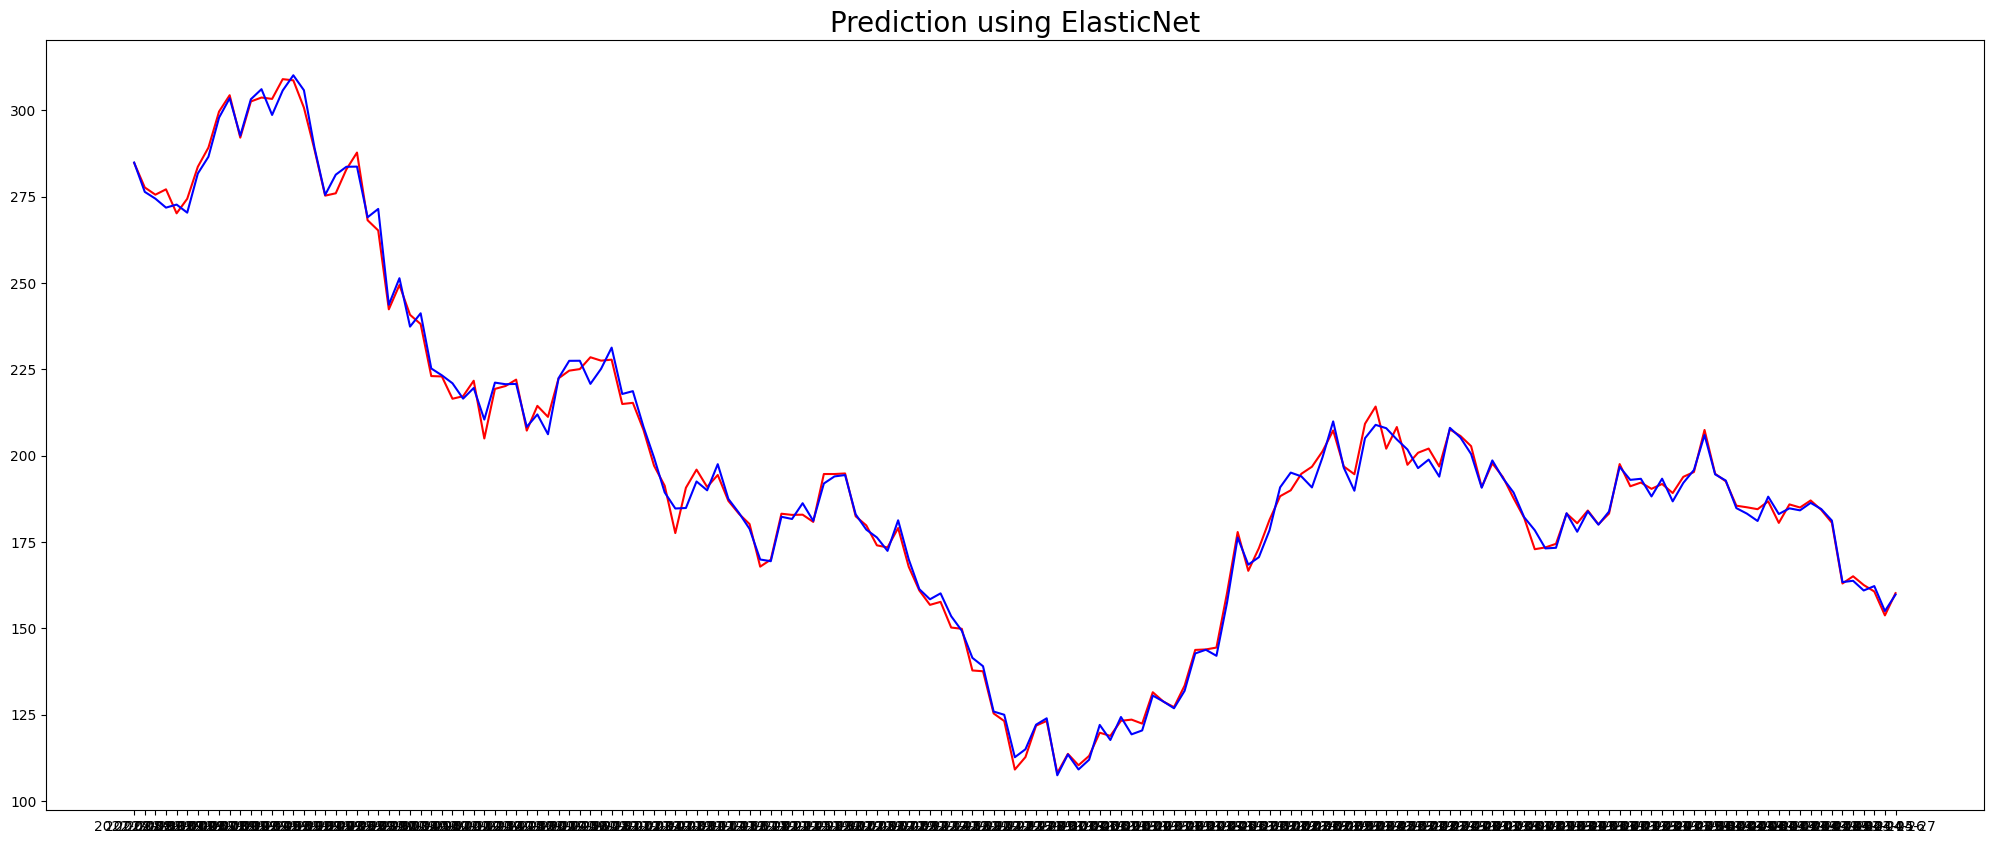

In [14]:
plt.figure(figsize = (25, 10))
plt.plot(y_test, color = 'red', label = 'actual')
plt.plot(y_test_pred_enet, color = 'blue', label = 'prediction')
plt.title("Prediction using ElasticNet", fontdict = {'fontsize': 20})
plt.show()